In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (30,10)
import numpy as np 
import pandas as pd 
import xgboost as xg 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE 

In [105]:
df_train=pd.read_csv("drive/MyDrive/Datasets-Collab/competitive-data-science-predict-future-sales/sales_train.csv")
df_test=pd.read_csv("drive/MyDrive/Datasets-Collab/competitive-data-science-predict-future-sales/test.csv")
shop=pd.read_csv("drive/MyDrive/Datasets-Collab/competitive-data-science-predict-future-sales/shops.csv")
items=pd.read_csv("drive/MyDrive/Datasets-Collab/competitive-data-science-predict-future-sales/items.csv")
item_categories=pd.read_csv("drive/MyDrive/Datasets-Collab/competitive-data-science-predict-future-sales/item_categories.csv")

In [106]:
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [107]:
df_train['item_cnt_day'].nunique()

198

In [108]:
df_train["date"]=pd.to_datetime(df_train["date"],format='%d.%m.%Y')
df_train['day']=df_train['date'].dt.day
df_train['month']=df_train['date'].dt.month
df_train['year']=df_train['date'].dt.year
df_train=df_train.sort_values(by='date')
df_test['month']=11
df_test['year']=2015


In [109]:
df_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
49800,2013-01-01,0,18,5823,2500.0,1.0,1,1,2013
29784,2013-01-01,0,27,5573,849.0,1.0,1,1,2013


In [110]:
df_test.head(2)

,ID,shop_id,item_id,month,year
0,0,5,5037,11,2015
1,1,5,5320,11,2015


##Concatenating train and test set

In [111]:
df_train=pd.merge(df_train,items[['item_id','item_category_id']],on='item_id')
df_test=pd.merge(df_test,items[['item_id','item_category_id']],on='item_id')

In [112]:
df_train=df_train.groupby(['year','month','shop_id','item_id','item_category_id']).agg({'item_price': 'mean', 
                                                                   'item_cnt_day': 'sum'
                                                                  }).reset_index()

Merging the dataframe

In [113]:
merged=pd.concat([df_train,df_test])

In [114]:
merged.columns

Index(['year', 'month', 'shop_id', 'item_id', 'item_category_id', 'item_price',
       'item_cnt_day', 'ID'],
      dtype='object')

In [115]:
merged.drop(['item_id','item_price'],axis=1,inplace=True)



## Hot - Label Encoding

In [116]:
final_df=pd.get_dummies(merged,columns=['item_category_id'])


In [117]:
final_df.columns

Index(['year', 'month', 'shop_id', 'item_cnt_day', 'ID', 'item_category_id_0',
       'item_category_id_1', 'item_category_id_2', 'item_category_id_3',
       'item_category_id_4', 'item_category_id_5', 'item_category_id_6',
       'item_category_id_7', 'item_category_id_8', 'item_category_id_9',
       'item_category_id_10', 'item_category_id_11', 'item_category_id_12',
       'item_category_id_13', 'item_category_id_14', 'item_category_id_15',
       'item_category_id_16', 'item_category_id_17', 'item_category_id_18',
       'item_category_id_19', 'item_category_id_20', 'item_category_id_21',
       'item_category_id_22', 'item_category_id_23', 'item_category_id_24',
       'item_category_id_25', 'item_category_id_26', 'item_category_id_27',
       'item_category_id_28', 'item_category_id_29', 'item_category_id_30',
       'item_category_id_31', 'item_category_id_32', 'item_category_id_33',
       'item_category_id_34', 'item_category_id_35', 'item_category_id_36',
       'item_categ

## Splitting Sequentially

In [118]:
df_train_final=final_df.iloc[:1609124,:]
df_test_final=final_df.iloc[1609124:,:]

In [119]:
df_test_final.shape

(214200, 89)

In [120]:
df_train_final.columns

Index(['year', 'month', 'shop_id', 'item_cnt_day', 'ID', 'item_category_id_0',
       'item_category_id_1', 'item_category_id_2', 'item_category_id_3',
       'item_category_id_4', 'item_category_id_5', 'item_category_id_6',
       'item_category_id_7', 'item_category_id_8', 'item_category_id_9',
       'item_category_id_10', 'item_category_id_11', 'item_category_id_12',
       'item_category_id_13', 'item_category_id_14', 'item_category_id_15',
       'item_category_id_16', 'item_category_id_17', 'item_category_id_18',
       'item_category_id_19', 'item_category_id_20', 'item_category_id_21',
       'item_category_id_22', 'item_category_id_23', 'item_category_id_24',
       'item_category_id_25', 'item_category_id_26', 'item_category_id_27',
       'item_category_id_28', 'item_category_id_29', 'item_category_id_30',
       'item_category_id_31', 'item_category_id_32', 'item_category_id_33',
       'item_category_id_34', 'item_category_id_35', 'item_category_id_36',
       'item_categ

In [121]:
X_train=df_train_final.iloc[:1259576,:].drop(['item_cnt_day','ID'],axis=1)
Y_train=df_train_final.iloc[:1259576,:]['item_cnt_day']
X_test= df_train_final.iloc[1259576:,:].drop(['item_cnt_day','ID'],axis=1)
Y_test= df_train_final.iloc[1259576:,:]['item_cnt_day']

## Model Training

In [122]:
train_dmatrix = xg.DMatrix(data = X_train, label = Y_train) 
test_dmatrix = xg.DMatrix(data = X_test, label = Y_test) 

In [ ]:
param = {"booster":"gblinear", "objective":"reg:linear"} 
  
xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 200) 
pred = np.round(xgb_r.predict(test_dmatrix) )

[15:52:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [102]:
rmse = np.sqrt(MSE(Y_test, pred)) 
print("RMSE : % f" %(rmse)) 

RMSE :  9.573735


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


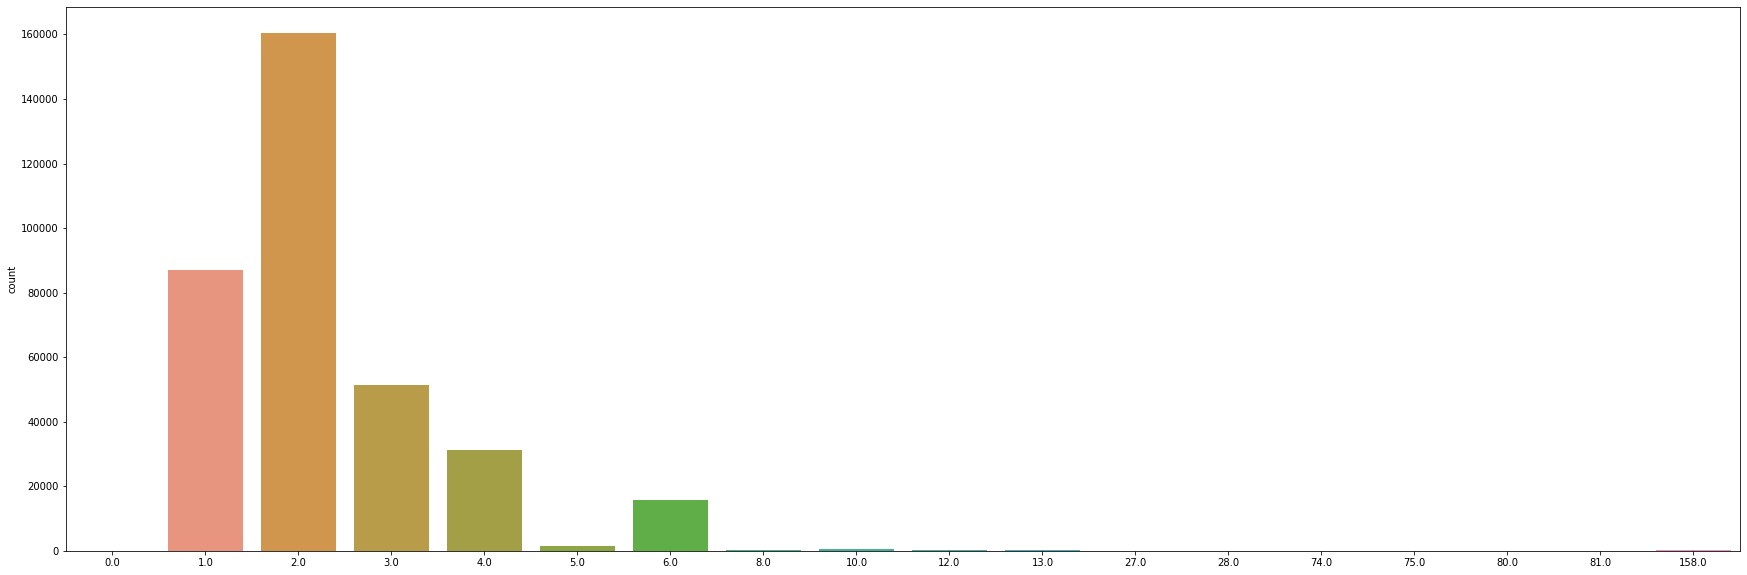

In [103]:
sns.countplot(pred)

## Making Submission

In [ ]:
final_df.shape

(1799395, 76)

In [ ]:
X_train=final_df.drop(['item_cnt_day'],axis=1)
Y_train=final_df['item_cnt_day']
train_dmatrix = xg.DMatrix(data = X_train, label = Y_train) 
xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 20) 

MemoryError: Unable to allocate 1.01 GiB for an array with shape (1799395, 75) and data type float64

In [ ]:
test_dmatrix=xg.DMatrix(data = df_test.drop(['ID'],axis=1)) 
pred = np.round(xgb_r.predict(test_dmatrix))

In [ ]:
submission=pd.DataFrame()
submission['ID']=df_test['ID']
submission['item_cnt_month']=pred

In [ ]:
submission['item_cnt_month'].nunique()

6

In [ ]:
submission.to_csv('Round 1| XGB | No Item Cat.csv',index=False)
